# Шишкин Александр Эдуардович, группа 0391, Лабораторная работа №2
Системы с нелинейным законом управления и идентификацией параметров.

### 1. Модель системы и закон управления

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

Сначала приведём расчет закона внутреннего управления для первого уравнения из отчёта первой лабораторной работы.

In [2]:
import sympy
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta=sympy.symbols('zeta')
I=sympy.symbols('I')
dP_d=sympy.symbols('dP_d')
G=sympy.symbols('G')

#запись уравнений
d_dP=17 * T + zeta - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

from sympy.solvers import solve
d_dP_d=dP_d-dP
T_d=(solve(d_dP-d_dP_d, 17*T)[0]) * (1 / 17)
print('Желаемая функция T_d(t) для эталонной модели d_dP_d = '+str(d_dP_d))
print('T_d = '+str(T_d))
print('')

Желаемая функция T_d(t) для эталонной модели d_dP_d = -dP + dP_d
T_d = 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588



Можно определить значение некотролируемого возмущения, как медианное.\
В данном случае медианное значение равно:
$\zeta_0\;=\;13.5$\
Также не учитывать $Δζ$, предположить что оно незначительно

In [3]:
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

psi_1 = d_dP_d
print(f'psi_1 = {str(psi_1)}')
dpsi_1 = sympy.diff(psi_1, dP)*d_dP
print(f'dpsi_1 = {str(dpsi_1)}')
T_i = solve(sympy.expand(T_1*dpsi_1 + psi_1), T)[0]
print(f'T = {str(T_i)}')
psi_2 = T_i - T
print(f'psi_2 = {str(psi_2)}')
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2,T)*dT
print(f'dpsi_2 = {str(dpsi_2)}')
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'I = {str(u_analytical)}')

psi_1 = -dP + dP_d
dpsi_1 = -17*T + 0.1*dP**3 - zeta - 9*sin(4*dP - 7) + 6
T = 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
psi_2 = -T + 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
dpsi_2 = -G*I + 0.1*T**3 + 2*T*cos(5*dP + 6) + 1 + 0.00588235294117647*(T_1*(3*dP**2 - 360.0*cos(4.0*dP - 7.0)) - 10.0)*(17*T - 0.1*dP**3 + zeta + 9*sin(4*dP - 7) - 6)/T_1
psi_2 = -T + 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
I = 1.17647058823529e-18*(T_1*T_2*(8.5e+16*T**3 + 2.55e+17*T*dP**2 - 3.06e+19*T*cos(4.0*dP - 7.0) + 1.7e+18*T*cos(5.0*dP + 6.0) - 1.5e+15*dP**5 + 1.8e+17*dP**3*cos(4.0*dP - 7.0) + 1.5e+16*dP**2*zeta + 1.35e+17*dP**2*sin(4.0*dP - 7.0) - 9.0e+16*dP**2 - 1.8e+18*zeta*cos(4.0*dP - 7.0) - 8.1e+18*sin(8.0*dP - 14.0) + 1.08e+19*cos(4.0*dP - 7.0) + 8.5e+17) + 5.0e+15*T_1*(-170.0*T + dP**3 - 10.0*zeta - 90.0*sin(4.0*

### 2. Вспомогательные модули для моделирования


Базовый класс для моделирования контроллера

In [4]:
!pip install digicon_mod

In [5]:
import math
import numpy
import matplotlib.pyplot as plt
import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [6]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP = 17*x[1] + zeta - 0.1*x[0]**3 + 9*math.sin(4*x[0] - 7) - 6
            dT = -0.1*x[1]**3 - 2*x[1]*math.cos(5*x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Вывод результатов моделирования

In [7]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

###3.  Моделирование САУ с аналитическим регулятором

In [8]:
list(u_analytical.free_symbols)

[G, T_1, T_2, zeta, dP, dP_d, T]

Инициализируем регулятор по методу AKAR в коде, возьмём значения T_1 > T_2, так как эталонная модель с T_2 ближе к реальному управляющему воздействию (силе тока в контуре).\
Т.е. регулирование T должно быть быстрее регулирования целевой переменной dP.

In [9]:
class AKAR(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.G=gain
        self.Pd=goal
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        return self.func(
            dP=x[0], T=x[1], dP_d=self.Pd, zeta=13.5, T_1=100, T_2=1, G=self.G
        )

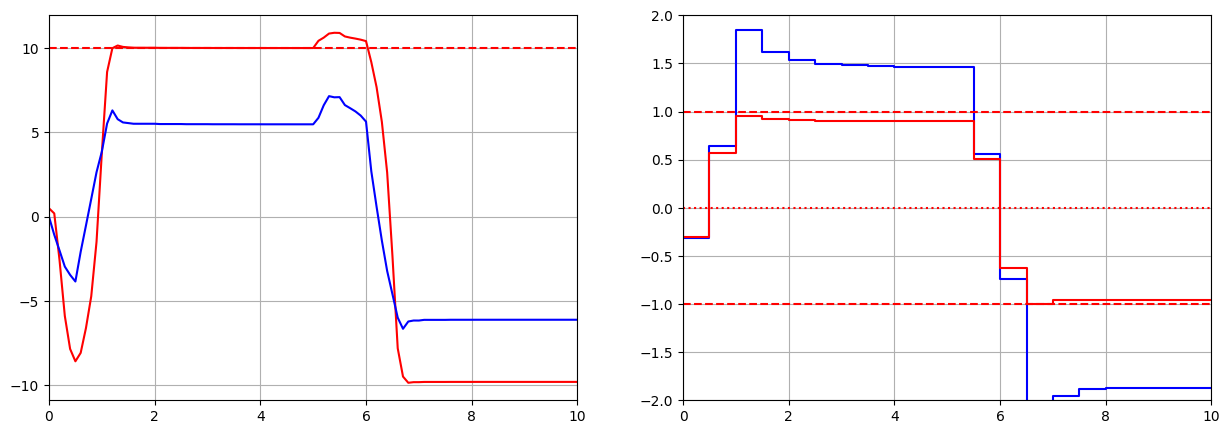

In [10]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = 10
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc = AKAR(goal=goal, gain=gain, dtu=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=plc, goal=goal)

По графикам видно, что аналитический регулятор по методу АКАР не справляется с задачей управления без интегральной компоненты.

### 4. САУ с аналитическим регулятором и интегральной компонентой



$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

Функции макропеременных:

$\psi_1 = dP - dP_d$

$\psi_2 = \psi_1 + z = dP - dP_d + z$

$\psi_3 = T_{internal} - T$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента

$\dot z = \frac 1 {T_2} \psi_1$

Параметр $v_0$:

$\zeta_0 = \zeta_{min} + \frac{(\zeta_{max}-\zeta_{min})}{2} = 4 + \frac{(23-4)}{2} = 13.5$

In [14]:
P = sympy.symbols('P')
T = sympy.symbols('T')
G = sympy.symbols('G')
I = sympy.symbols('I')
z = sympy.symbols('z')
dP_d = sympy.symbols('dP_d')
zeta0 = sympy.symbols('zeta0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')

#запись уравнений
d_dP=17 * T + zeta0 - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

#метод акар с интегральной компонентой
psi_1 = dP - dP_d
dz = 1/T_2*psi_1
psi_2 = psi_1 + z
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2, z)*dz
T_i = solve(sympy.expand(T_1*dpsi_2 + psi_2),T)[0]
print(f'dz = {dz}')
print(f'T = {str(T_i)}')
psi_3 = T_i - T
dpsi_3 = sympy.diff(psi_3,dP)*d_dP + sympy.diff(psi_3,T)*dT + sympy.diff(psi_3,z)*dz
u = solve(sympy.expand(T_3*dpsi_3 + psi_3),I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'psi_3 = {str(psi_3)}')
print(f'I = {str(u_analytical)}')

dz = (dP - dP_d)/T_2
T = 0.00588235294117647*(T_1*T_2*(dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 10.0*T_1*(-dP + dP_d) + 10.0*T_2*(-dP + dP_d - z))/(T_1*T_2)
psi_2 = dP - dP_d + z
psi_3 = -T + 0.00588235294117647*(T_1*T_2*(dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 10.0*T_1*(-dP + dP_d) + 10.0*T_2*(-dP + dP_d - z))/(T_1*T_2)
I = 1.17647058823529e-18*(T_1*T_2*T_3*(8.5e+16*T**3 + 2.55e+17*T*dP**2 - 3.06e+19*T*cos(4.0*dP - 7.0) + 1.7e+18*T*cos(5.0*dP + 6.0) - 1.5e+15*dP**5 + 1.8e+17*dP**3*cos(4.0*dP - 7.0) + 1.5e+16*dP**2*zeta0 + 1.35e+17*dP**2*sin(4.0*dP - 7.0) - 9.0e+16*dP**2 - 1.8e+18*zeta0*cos(4.0*dP - 7.0) - 8.1e+18*sin(8.0*dP - 14.0) + 1.08e+19*cos(4.0*dP - 7.0) + 8.5e+17) + 5.0e+15*T_1*T_2*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+15*T_1*T_3*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+16*T_1*(-dP + dP_d) + 5.0e+15*T_2*T_3*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+16*T_2*(-dP 

Выберем коэффициенты T_1 = 100, T_2 = 10, T_3 = 1

Подпрограмма для реализации нелинейного регулятора с интегральной компонентой.

In [32]:
class AKAR_i(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt, T1, T2, T3, zeta0):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.G=gain
        self.dP_d=goal
        self.T1 = T1
        self.T2 = T2
        self.T3 = T3
        self.zeta0 = zeta0
        self.z = []
        self.zt = []
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        dP = x[0]
        T = x[1]
        T_1 = self.T1
        T_2 = self.T2
        T_3 = self.T3
        dP_d = self.dP_d
        G = self.G
        zeta_0 = self.zeta0
        zeta0 = zeta_0
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else:
            z = self.z[-1] - dt/T_2*(dP - dP_d)
        self.z.append(z)
        self.zt.append(t)
        return self.func(
            G=G, dP=dP, zeta0=zeta0, dP_d=dP_d, z=z, T=T, T_3=T_3, T_1=T_1, T_2=T_2
        )

Моделирование и результаты.

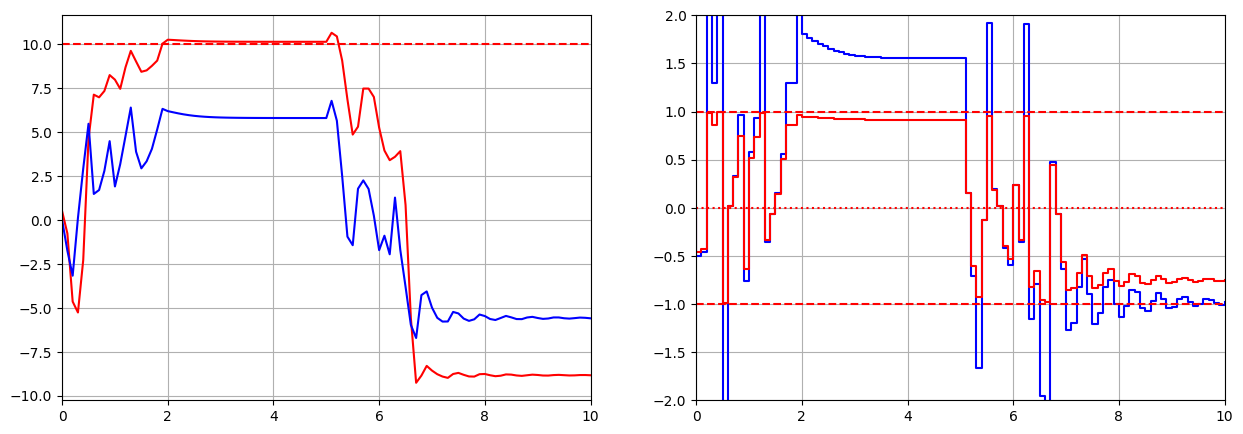

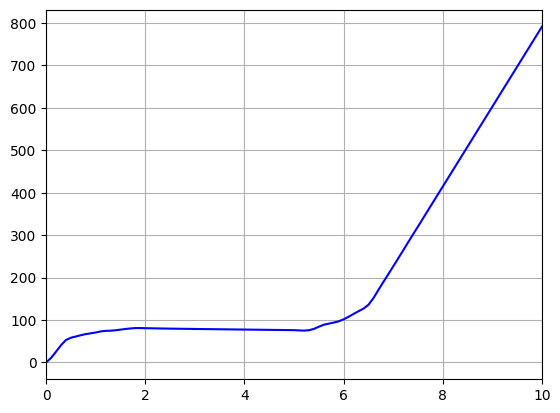

In [43]:
tk=10
reg = AKAR_i(goal=10, gain=35, dt=0.1, T1=100, T2=0.1, T3=10, zeta0=13.5)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=reg.dP_d)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()

Система точно так же ведёт себя и с интегральной компонентой, однако ошибка накапливается.